# Preprocessing

In [1]:
import sqlite3
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.graphics.regressionplots import abline_plot

### COVID-19 Data - covid_df

In [2]:
# Import covid table as dataframe
con = sqlite3.connect("../Data/data.db")
covid_df = pd.read_sql_query("SELECT * FROM covid", con)
print(covid_df.dtypes)
print(covid_df.shape)
covid_df.head()

date                        object
state                       object
positiveIncrease             int64
totalTestResultsIncrease     int64
dtype: object
(18223, 4)


,date,state,positiveIncrease,totalTestResultsIncrease
0,2021-02-20 00:00:00,AK,0,0
1,2021-02-20 00:00:00,AL,774,5436
2,2021-02-20 00:00:00,AR,517,3060
3,2021-02-20 00:00:00,AZ,2047,45153
4,2021-02-20 00:00:00,CA,6668,192222


In [3]:
# Change date to datetime
covid_df = covid_df.drop(columns='totalTestResultsIncrease')
covid_df['date'] = pd.to_datetime(covid_df['date'])
print(covid_df.dtypes)
covid_df.head()

date                datetime64[ns]
state                       object
positiveIncrease             int64
dtype: object


,date,state,positiveIncrease
0,2021-02-20,AK,0
1,2021-02-20,AL,774
2,2021-02-20,AR,517
3,2021-02-20,AZ,2047
4,2021-02-20,CA,6668


In [4]:
# Define cutoff dates and encoding
months = [3,4,5,6,7,8,9]
start = [pd.Timestamp("3-15-2020"),
         pd.Timestamp("4-15-2020"),
         pd.Timestamp("5-15-2020"),
         pd.Timestamp("6-15-2020"),
         pd.Timestamp("7-15-2020"),
         pd.Timestamp("8-15-2020"),
         pd.Timestamp("9-15-2020")]
end = [pd.Timestamp("4-15-2020"),
       pd.Timestamp("5-15-2020"),
       pd.Timestamp("6-15-2020"),
       pd.Timestamp("7-15-2020"),
       pd.Timestamp("8-15-2020"),
       pd.Timestamp("9-15-2020"),
       pd.Timestamp("10-15-2020")]

# Include new month column
for i in range(len(months)):
    covid_df.loc[(covid_df['date']>=start[i]) & (covid_df['date']<end[i]), "month"] = months[i]

# Drop rows outside of daterange
covid_df = covid_df.dropna()
print(covid_df.shape)

covid_df.head()

(10914, 4)


,date,state,positiveIncrease,month
6579,2020-10-14,AK,155,9.0
6580,2020-10-14,AL,784,9.0
6581,2020-10-14,AR,1079,9.0
6582,2020-10-14,AZ,901,9.0
6583,2020-10-14,CA,2666,9.0


In [5]:
# Groupby state and month and sum
covid_df = covid_df.groupby(['state','month']).sum()
covid_df = covid_df.reset_index()
print(covid_df.shape)
covid_df.head()

(357, 3)


,state,month,positiveIncrease
0,AK,3.0,285
1,AK,4.0,104
2,AK,5.0,276
3,AK,6.0,915
4,AK,7.0,2498


In [6]:
# Calculate change in infections by state and month

# months = [4,5,6,7,8,9]
# states = covid_df['state'].unique()
# for month in months:
#     for state in states:
#         curr_month = covid_df[(covid_df['month'] == month) & (covid_df['state'] == state)].positiveIncrease.item()
#         prev_month = covid_df[(covid_df['month'] == month-1) & (covid_df['state'] == state)].positiveIncrease.item()
#         if prev_month != 0:
#             covid_df.loc[(covid_df['month'] == month) & (covid_df['state'] == state), 'covid_change'] = \
#             (curr_month-prev_month)/prev_month

covid_df = covid_df.sort_values(by=['state','month'])
covid_df['covid_change'] = covid_df['positiveIncrease'].pct_change()

# Keep data from Apr
covid_df = covid_df[covid_df['month']>=4]
print(covid_df.shape)
covid_df.head()

(306, 4)


,state,month,positiveIncrease,covid_change
1,AK,4.0,104,-0.635088
2,AK,5.0,276,1.653846
3,AK,6.0,915,2.315217
4,AK,7.0,2498,1.730055
5,AK,8.0,2272,-0.090472


In [7]:
# Get population of states
pop_df = pd.read_sql_query("SELECT state, population FROM policy", con)
pop_df.head()

,state,population
0,AL,4887871
1,AK,737438
2,AZ,7171646
3,AR,3013825
4,CA,39557045


In [8]:
# Merge tables
covid_df = pd.merge(covid_df, pop_df, on='state')
covid_df.head()

,state,month,positiveIncrease,covid_change,population
0,AK,4.0,104,-0.635088,737438
1,AK,5.0,276,1.653846,737438
2,AK,6.0,915,2.315217,737438
3,AK,7.0,2498,1.730055,737438
4,AK,8.0,2272,-0.090472,737438


In [9]:
# Calculate new cases per capita
covid_df['covid_percap'] = covid_df['positiveIncrease']/covid_df['population']
covid_df = covid_df.astype({'month':'int64'})
print(covid_df.shape)
print(covid_df.dtypes)
covid_df.head()

(306, 6)
state                object
month                 int64
positiveIncrease      int64
covid_change        float64
population            int64
covid_percap        float64
dtype: object


,state,month,positiveIncrease,covid_change,population,covid_percap
0,AK,4,104,-0.635088,737438,0.000141
1,AK,5,276,1.653846,737438,0.000374
2,AK,6,915,2.315217,737438,0.001241
3,AK,7,2498,1.730055,737438,0.003387
4,AK,8,2272,-0.090472,737438,0.003081


### Policy Data - policy_df

In [10]:
raw = pd.read_sql_query("SELECT * FROM policy", con)
# Drop pop density and population columns 
raw = raw.drop(columns=['pop_density', 'population'])
print(raw.dtypes)
raw.head()

state                    object
state_of_emergency       object
stay_at_home             object
stay_at_home_end         object
business_closure         object
business_closure_end     object
facemask_mandate         object
facemask_mandate_end     object
quaratine_mandate        object
quaratine_mandate_end    object
dtype: object


,state,state_of_emergency,stay_at_home,stay_at_home_end,business_closure,business_closure_end,facemask_mandate,facemask_mandate_end,quaratine_mandate,quaratine_mandate_end
0,AL,2020-03-13 00:00:00,2020-04-04 00:00:00,2020-04-30 00:00:00,2020-03-28 00:00:00,2020-04-30 00:00:00,2020-07-16 00:00:00,None,None,None
1,AK,2020-03-11 00:00:00,2020-03-28 00:00:00,2020-04-24 00:00:00,2020-03-24 00:00:00,2020-04-24 00:00:00,2020-04-24 00:00:00,2020-05-22 00:00:00,2020-03-25 00:00:00,2021-02-14 00:00:00
2,AZ,2020-03-11 00:00:00,2020-03-31 00:00:00,2020-05-16 00:00:00,2020-03-31 00:00:00,2020-05-08 00:00:00,None,None,None,2020-05-12 00:00:00
3,AR,2020-03-11 00:00:00,None,None,2020-04-06 00:00:00,2020-05-04 00:00:00,2020-07-20 00:00:00,None,None,2020-06-15 00:00:00
4,CA,2020-03-04 00:00:00,2020-03-19 00:00:00,None,2020-03-19 00:00:00,2020-05-08 00:00:00,2020-06-18 00:00:00,None,None,None


In [11]:
# Change columns to Datetime object, convert date to only the month value
for i in range(1, raw.shape[1]):
    raw.iloc[:, i] = pd.to_datetime(raw.iloc[:, i], errors="coerce")
    for j in range(0, raw.shape[0]): 
        # Set month to inf if it is out of range of 2020
        if raw.iloc[j, i].year == 2021:
            raw.iloc[j, i] = np.inf
        else:
            raw.iloc[j, i] = raw.iloc[j, i].month
print(raw.dtypes)
raw = raw.fillna(np.Inf)
raw.head()

state                    object
state_of_emergency       object
stay_at_home             object
stay_at_home_end         object
business_closure         object
business_closure_end     object
facemask_mandate         object
facemask_mandate_end     object
quaratine_mandate        object
quaratine_mandate_end    object
dtype: object


,state,state_of_emergency,stay_at_home,stay_at_home_end,business_closure,business_closure_end,facemask_mandate,facemask_mandate_end,quaratine_mandate,quaratine_mandate_end
0,AL,3,4.0,4.0,3.0,4.0,7.0,inf,inf,inf
1,AK,3,3.0,4.0,3.0,4.0,4.0,5.0,3.0,inf
2,AZ,3,3.0,5.0,3.0,5.0,inf,inf,inf,5.0
3,AR,3,inf,inf,4.0,5.0,7.0,inf,inf,6.0
4,CA,3,3.0,inf,3.0,5.0,6.0,inf,inf,inf


In [12]:
# Encode data where 1 indicates that policy is active and 2 indicates that policy is inactive
policy_df = pd.DataFrame(columns = ['state','month','state_of_emergency','stay_at_home', \
                                         'business_closure','facemask_mandate','quarantine_mandate'])
months = [4,5,6,7,8,9]
states = covid_df['state'].unique()
for month in months:
    for state in states:
        row = raw[raw['state'] == state]
        emergency, home, business, facemask, quarantine = 0, 0, 0, 0, 0
        # Encode as 1 if month is between start and end
        if month >= row.state_of_emergency.item():
            emergency = 1
        if month >= row.stay_at_home.item() and month <= row.stay_at_home_end.item():
            home = 1
        if month >= row.business_closure.item() and month <= row.business_closure_end.item():
            business = 1
        if month >= row.facemask_mandate.item() and month <= row.facemask_mandate_end.item():
            facemask = 1
        if month >= row.quaratine_mandate.item() and month <= row.quaratine_mandate_end.item():
            quarantine = 1
        # Add to dataframe
        policy_df = policy_df.append({'state':state,\
                                    'month':month,\
                                    'state_of_emergency':emergency,\
                                    'stay_at_home':home,\
                                    'business_closure':business,\
                                    'facemask_mandate':facemask,\
                                    'quarantine_mandate':quarantine}, ignore_index=True)
print(policy_df.dtypes)
policy_df.head()

state                 object
month                 object
state_of_emergency    object
stay_at_home          object
business_closure      object
facemask_mandate      object
quarantine_mandate    object
dtype: object


,state,month,state_of_emergency,stay_at_home,business_closure,facemask_mandate,quarantine_mandate
0,AK,4,1,1,1,1,1
1,AL,4,1,1,1,0,0
2,AR,4,1,0,1,0,0
3,AZ,4,1,1,1,0,0
4,CA,4,1,1,1,0,0


### Data Exploration

In [13]:
policy_df = policy_df.astype('int',errors='ignore')
# Check variance of data
print(policy_df.var())
policy_df = policy_df.drop(columns='state_of_emergency')

month                 2.926230
state_of_emergency    0.000000
stay_at_home          0.222951
business_closure      0.219576
facemask_mandate      0.250134
quarantine_mandate    0.143673
dtype: float64


In [14]:
policy_df[['stay_at_home','business_closure','facemask_mandate','quarantine_mandate']].corr()

,stay_at_home,business_closure,facemask_mandate,quarantine_mandate
stay_at_home,1.000000,0.711287,-0.087931,0.079383
business_closure,0.711287,1.000000,-0.250588,0.071123
facemask_mandate,-0.087931,-0.250588,1.000000,0.170974
quarantine_mandate,0.079383,0.071123,0.170974,1.000000


### Flight Data - flight_df

In [15]:
flight_df = pd.read_sql_query("SELECT * FROM flight WHERE (month >= 3)", con)
flight_df.head()

,origin_state,dest_state,month,monthly_pax
0,AK,AK,3.0,56336.281143
1,AK,AK,4.0,10187.576905
2,AK,AK,5.0,20472.748260
3,AK,AK,6.0,41179.674835
4,AK,AK,7.0,52228.927140


# Model 1 - Simple Regression

In [16]:
# Find total number of incoming flights for each state
flight_dest_state = flight_df.groupby(['dest_state', 'month']).sum().reset_index()
flight_dest_state = flight_dest_state.rename(columns={'dest_state':'state'})
print(flight_dest_state.shape)
flight_dest_state.head()

(364, 3)


,state,month,monthly_pax
0,AK,3.0,138235.631149
1,AK,4.0,26092.783185
2,AK,5.0,52663.559269
3,AK,6.0,110763.657546
4,AK,7.0,158323.464182


In [17]:
flight_dest_state = flight_dest_state.sort_values(by=['state','month'])
flight_dest_state['flight_change'] = flight_dest_state['monthly_pax'].pct_change()
flight_dest_state = flight_dest_state[flight_dest_state['month']>=4]
flight_dest_state.head()

,state,month,monthly_pax,flight_change
1,AK,4.0,26092.783185,-0.811244
2,AK,5.0,52663.559269,1.018319
3,AK,6.0,110763.657546,1.103232
4,AK,7.0,158323.464182,0.429381
5,AK,8.0,151104.177926,-0.045598


In [18]:
# Combine covid and flight data
model1_df = covid_df.merge(flight_dest_state, how="inner", on=['state', 'month'])
print(model1_df.shape)
model1_df.head()

(294, 8)


,state,month,positiveIncrease,covid_change,population,covid_percap,monthly_pax,flight_change
0,AK,4,104,-0.635088,737438,0.000141,26092.783185,-0.811244
1,AK,5,276,1.653846,737438,0.000374,52663.559269,1.018319
2,AK,6,915,2.315217,737438,0.001241,110763.657546,1.103232
3,AK,7,2498,1.730055,737438,0.003387,158323.464182,0.429381
4,AK,8,2272,-0.090472,737438,0.003081,151104.177926,-0.045598


In [19]:
# Find per capita number of flights
model1_df['flight_percap'] = model1_df['monthly_pax']/model1_df['population']
model1_df.head()

,state,month,positiveIncrease,covid_change,population,covid_percap,monthly_pax,flight_change,flight_percap
0,AK,4,104,-0.635088,737438,0.000141,26092.783185,-0.811244,0.035383
1,AK,5,276,1.653846,737438,0.000374,52663.559269,1.018319,0.071414
2,AK,6,915,2.315217,737438,0.001241,110763.657546,1.103232,0.150201
3,AK,7,2498,1.730055,737438,0.003387,158323.464182,0.429381,0.214694
4,AK,8,2272,-0.090472,737438,0.003081,151104.177926,-0.045598,0.204904


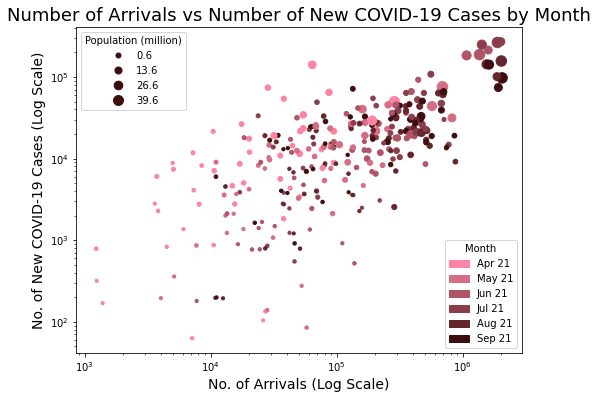

In [20]:
# Data exploration

# Size based on population size
pop_norm = (model1_df['population'] - model1_df['population'].min()) / (model1_df['population'].max() - model1_df['population'].min())
pop_norm = (pop_norm+0.1)*100

# Color based on months
# colors = {4:'#7FA3AD', 5:"#678D9A", 6:"#4F7887", 7:"#376273",8:"#1F4D60",9:"#07374D"}
colors = {4:'#FB85A3', 5:"#D56D85", 6:"#AF5567", 7:"#8A3D4A",8:"#64252C",9:"#3E0D0E"}

# scatter-plot data
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(model1_df['monthly_pax'], model1_df['positiveIncrease'], c=model1_df['month'].map(colors), s=pop_norm)
ax.set_title("Number of Arrivals vs Number of New COVID-19 Cases by Month", fontsize=18)
ax.set_xlabel("No. of Arrivals (Log Scale)", fontsize=14)
ax.set_ylabel("No. of New COVID-19 Cases (Log Scale)", fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')

# Legend for color
legend1  = ax.legend(handles=[mpatches.Patch(color='#FB85A3', label='Apr 21'),mpatches.Patch(color='#D56D85', label='May 21'),
                              mpatches.Patch(color='#AF5567', label='Jun 21'),mpatches.Patch(color='#8A3D4A', label='Jul 21'),
                              mpatches.Patch(color='#64252C', label='Aug 21'),mpatches.Patch(color='#3E0D0E', label='Sep 21')],
                    title = "Month", loc="lower right")
ax.add_artist(legend1)

# Legend for size
handles, labels = scatter.legend_elements(prop="sizes", num=5, color="#3E0D0E")
min_pop, max_pop = model1_df['population'].min()/1000000, model1_df['population'].max()/1000000
interval = (max_pop - min_pop)/3
labels = [round(min_pop,1), round(min_pop+interval,1), round(min_pop+interval*2,1), round(max_pop,1)]
legend2 = ax.legend(handles, labels, title="Population (million)")

In [21]:
# Fit linear regression model
model = sm.OLS(model1_df['positiveIncrease'],sm.add_constant(model1_df['monthly_pax']))
# model = sm.OLS(model1_df['covid_change'],sm.add_constant(model1_df['flight_change']))
# model = sm.OLS(model1_df['covid_percap'],sm.add_constant(model1_df['flight_percap']))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       positiveIncrease   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     458.8
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           7.79e-62
Time:                        12:00:10   Log-Likelihood:                -3379.7
No. Observations:                 294   AIC:                             6763.
Df Residuals:                     292   BIC:                             6771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4895.0449   1663.104      2.943      

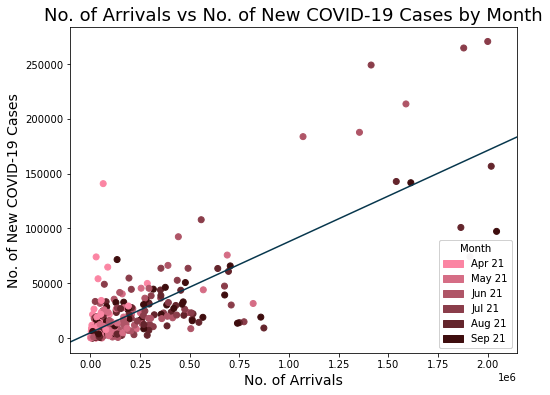

In [22]:
# Plot regression plot

# scatter-plot data
fig, ax = plt.subplots(figsize=(8,6))
colors = {4:'#FB85A3', 5:"#D56D85", 6:"#AF5567", 7:"#8A3D4A",8:"#64252C",9:"#3E0D0E"}
scatter = ax.scatter(model1_df['monthly_pax'], model1_df['positiveIncrease'], c=model1_df['month'].map(colors))
ax.set_title("No. of Arrivals vs No. of New COVID-19 Cases by Month", fontsize=18)
ax.set_xlabel("No. of Arrivals", fontsize=14)
ax.set_ylabel("No. of New COVID-19 Cases",fontsize=14)


# Color based on months
legend1  = ax.legend(handles=[mpatches.Patch(color='#FB85A3', label='Apr 21'),mpatches.Patch(color='#D56D85', label='May 21'),
                              mpatches.Patch(color='#AF5567', label='Jun 21'),mpatches.Patch(color='#8A3D4A', label='Jul 21'),
                              mpatches.Patch(color='#64252C', label='Aug 21'),mpatches.Patch(color='#3E0D0E', label='Sep 21')],
                    title = "Month", loc="lower right")
ax.add_artist(legend1)

# plot regression line
fig = abline_plot(model_results=results, ax=ax, color="#07374D")

In [23]:
results.params

const          4895.044918
monthly_pax       0.083107
dtype: float64

In [24]:
results.pvalues

const          3.507764e-03
monthly_pax    7.785749e-62
dtype: float64

# Model 1a(w) - Simple Regression (Weighted)

In [25]:
# Multiply monthly_pax with origin_state's per_capita
flight_df = flight_df[flight_df['month']>=4]
flights_weighted = flight_df.merge(covid_df, how="left", left_on=['origin_state', 'month'], right_on=['state','month'])
flights_weighted['weighted_pax'] = flights_weighted['monthly_pax']*flights_weighted['covid_percap']
flights_weighted.head()

,origin_state,dest_state,month,monthly_pax,state,positiveIncrease,covid_change,population,covid_percap,weighted_pax
0,AK,AK,4.0,10187.576905,AK,104.0,-0.635088,737438.0,0.000141,1.436742
1,AK,AK,5.0,20472.748260,AK,276.0,1.653846,737438.0,0.000374,7.662310
2,AK,AK,6.0,41179.674835,AK,915.0,2.315217,737438.0,0.001241,51.095011
3,AK,AK,7.0,52228.927140,AK,2498.0,1.730055,737438.0,0.003387,176.920446
4,AK,AK,8.0,50918.481872,AK,2272.0,-0.090472,737438.0,0.003081,156.876633


In [26]:
# Aggregate by dest_state
flights_weighted = flights_weighted.groupby(['dest_state', 'month']).sum().reset_index()
flights_weighted = flights_weighted.rename(columns={'dest_state':'state'})
flights_weighted = flights_weighted[['state','month','weighted_pax']]
print(flights_weighted.shape)
flights_weighted.head()

(312, 3)


,state,month,weighted_pax
0,AK,4.0,25.351912
1,AK,5.0,60.627639
2,AK,6.0,329.105647
3,AK,7.0,738.584167
4,AK,8.0,501.866129


In [27]:
# Combine covid and flight data
model2_df = covid_df.merge(flights_weighted, how="inner", on=['state', 'month'])
# Find per capita number of weighted flights
model2_df['weighted_percap'] = model2_df['weighted_pax']/model2_df['population']
print(model2_df.shape)
model2_df.head()

(294, 8)


,state,month,positiveIncrease,covid_change,population,covid_percap,weighted_pax,weighted_percap
0,AK,4,104,-0.635088,737438,0.000141,25.351912,0.000034
1,AK,5,276,1.653846,737438,0.000374,60.627639,0.000082
2,AK,6,915,2.315217,737438,0.001241,329.105647,0.000446
3,AK,7,2498,1.730055,737438,0.003387,738.584167,0.001002
4,AK,8,2272,-0.090472,737438,0.003081,501.866129,0.000681


In [28]:
# Fit linear regression model
model = sm.OLS(model2_df['covid_percap'],sm.add_constant(model2_df['weighted_percap']))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           covid_percap   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     20.29
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           9.61e-06
Time:                        12:00:11   Log-Likelihood:                 1317.4
No. Observations:                 294   AIC:                            -2631.
Df Residuals:                     292   BIC:                            -2623.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0029      0.000     

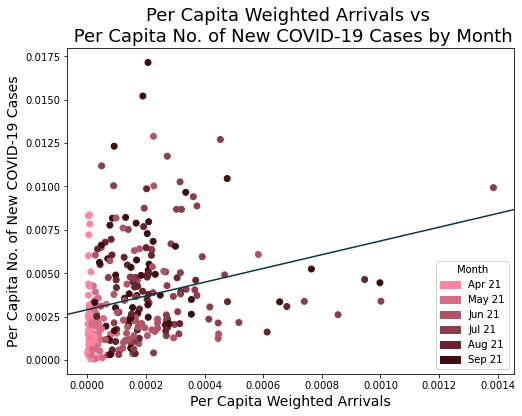

In [29]:
# Plot regression plot

# scatter-plot data
fig, ax = plt.subplots(figsize=(8,6))
colors = {4:'#FB85A3', 5:"#D56D85", 6:"#AF5567", 7:"#8A3D4A",8:"#64252C",9:"#3E0D0E"}
scatter = ax.scatter(model2_df['weighted_percap'], model1_df['covid_percap'], c=model1_df['month'].map(colors))
ax.set_title("Per Capita Weighted Arrivals vs \n Per Capita No. of New COVID-19 Cases by Month", fontsize=18)
ax.set_xlabel("Per Capita Weighted Arrivals", fontsize=14)
ax.set_ylabel("Per Capita No. of New COVID-19 Cases",fontsize=14)

# Color based on months
legend1  = ax.legend(handles=[mpatches.Patch(color='#FB85A3', label='Apr 21'),mpatches.Patch(color='#D56D85', label='May 21'),
                              mpatches.Patch(color='#AF5567', label='Jun 21'),mpatches.Patch(color='#8A3D4A', label='Jul 21'),
                              mpatches.Patch(color='#64252C', label='Aug 21'),mpatches.Patch(color='#3E0D0E', label='Sep 21')],
                    title = "Month", loc="lower right")
ax.add_artist(legend1)

# plot regression line
fig = abline_plot(model_results=results, ax=ax, color="#07374D")

In [30]:
results.params

const              0.002897
weighted_percap    3.960357
dtype: float64

In [31]:
results.pvalues

const              9.429380e-33
weighted_percap    9.611308e-06
dtype: float64

In [32]:
# Export for data visualization
model2_df.to_csv("../Data/viz/analysis.csv")

# Model 2 Polynomial Regression

In [33]:
model2_df.head()

,state,month,positiveIncrease,covid_change,population,covid_percap,weighted_pax,weighted_percap
0,AK,4,104,-0.635088,737438,0.000141,25.351912,0.000034
1,AK,5,276,1.653846,737438,0.000374,60.627639,0.000082
2,AK,6,915,2.315217,737438,0.001241,329.105647,0.000446
3,AK,7,2498,1.730055,737438,0.003387,738.584167,0.001002
4,AK,8,2272,-0.090472,737438,0.003081,501.866129,0.000681


Degree:  1
0.06498585528033118
Degree:  2
0.08085463680726113
Degree:  3
0.11823210045800814
Degree:  4
0.1183667794599027
Degree:  5
0.1193088559281339
Degree:  6
0.11934525053198453
Degree:  7
0.1196584423711089
Degree:  8
0.11966318696903855
Degree:  9
0.11976779013915484


Text(0.5, 1.0, 'Degree of Polynomial Model vs R-Squared')

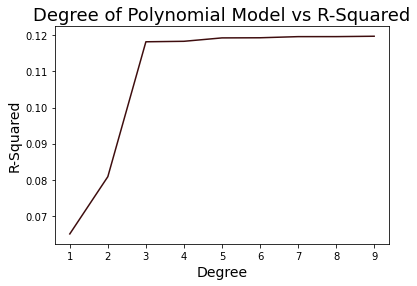

In [34]:
from sklearn.metrics import r2_score

d = range(1,10)
r2 = []
for i in d:
    mymodel = np.poly1d(np.polyfit(model2_df['weighted_percap'], model2_df['covid_percap'], i))
    r_squared = r2_score(model2_df['covid_percap'], mymodel(model2_df['weighted_percap']))
    r2.append(r_squared)
    print("Degree: ", i)
    print(r_squared)

#  Visualize   
plt.plot(d, r2, color="#3E0D0E")
plt.xlabel("Degree", fontsize=14)
plt.ylabel("R-Squared", fontsize=14)
plt.title("Degree of Polynomial Model vs R-Squared", fontsize=18)

In [35]:
polynomial_df = model2_df.copy()
polynomial_df['weighted_percap2'] = polynomial_df['weighted_percap']**2
polynomial_df['weighted_percap3'] = polynomial_df['weighted_percap']**3
print(polynomial_df.shape)
polynomial_df.head()

(294, 10)


,state,month,positiveIncrease,covid_change,population,covid_percap,weighted_pax,weighted_percap,weighted_percap2,weighted_percap3
0,AK,4,104,-0.635088,737438,0.000141,25.351912,0.000034,1.181872e-09,4.063082e-14
1,AK,5,276,1.653846,737438,0.000374,60.627639,0.000082,6.759122e-09,5.556936e-13
2,AK,6,915,2.315217,737438,0.001241,329.105647,0.000446,1.991680e-07,8.888520e-11
3,AK,7,2498,1.730055,737438,0.003387,738.584167,0.001002,1.003111e-06,1.004670e-09
4,AK,8,2272,-0.090472,737438,0.003081,501.866129,0.000681,4.631533e-07,3.152007e-10


In [36]:
model = sm.OLS(polynomial_df['covid_percap'],sm.add_constant(polynomial_df[['weighted_percap','weighted_percap2','weighted_percap3']]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           covid_percap   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     12.96
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           5.72e-08
Time:                        12:00:14   Log-Likelihood:                 1326.0
No. Observations:                 294   AIC:                            -2644.
Df Residuals:                     290   BIC:                            -2629.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0021      0.000  

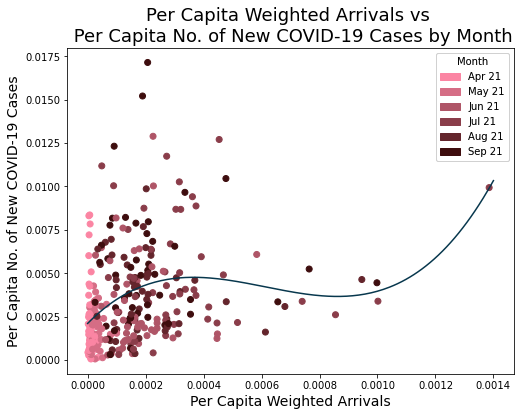

In [37]:
# Plot regression plot

# scatter-plot data
fig, ax = plt.subplots(figsize=(8,6))
colors = {4:'#FB85A3', 5:"#D56D85", 6:"#AF5567", 7:"#8A3D4A",8:"#64252C",9:"#3E0D0E"}
scatter = ax.scatter(polynomial_df['weighted_percap'], polynomial_df['covid_percap'], c=model1_df['month'].map(colors))
ax.set_title("Per Capita Weighted Arrivals vs \n Per Capita No. of New COVID-19 Cases by Month", fontsize=18)
ax.set_xlabel("Per Capita Weighted Arrivals", fontsize=14)
ax.set_ylabel("Per Capita No. of New COVID-19 Cases",fontsize=14)

# Color based on months
legend1  = ax.legend(handles=[mpatches.Patch(color='#FB85A3', label='Apr 21'),mpatches.Patch(color='#D56D85', label='May 21'),
                              mpatches.Patch(color='#AF5567', label='Jun 21'),mpatches.Patch(color='#8A3D4A', label='Jul 21'),
                              mpatches.Patch(color='#64252C', label='Aug 21'),mpatches.Patch(color='#3E0D0E', label='Sep 21')],
                    title = "Month")
ax.add_artist(legend1)

# plot regression line
mymodel = np.poly1d(np.polyfit(polynomial_df['weighted_percap'], polynomial_df['covid_percap'], 3))
myline = np.linspace(0, 0.0014, 200)
plt.plot(myline, mymodel(myline),color="#07374D")

In [38]:
results.pvalues

const               1.713001e-12
weighted_percap     2.771019e-07
weighted_percap2    9.774320e-05
weighted_percap3    5.266652e-04
dtype: float64

# Hypothesis 3 - Adding in Controls

In [39]:
# Merge with policy table
weighted_control = model2_df.merge(policy_df, how="inner", on=['state', 'month'])
print(weighted_control.shape)
weighted_control.head()

(294, 12)


,state,month,positiveIncrease,covid_change,population,covid_percap,weighted_pax,weighted_percap,stay_at_home,business_closure,facemask_mandate,quarantine_mandate
0,AK,4,104,-0.635088,737438,0.000141,25.351912,0.000034,1,1,1,1
1,AK,5,276,1.653846,737438,0.000374,60.627639,0.000082,0,0,1,1
2,AK,6,915,2.315217,737438,0.001241,329.105647,0.000446,0,0,0,1
3,AK,7,2498,1.730055,737438,0.003387,738.584167,0.001002,0,0,0,1
4,AK,8,2272,-0.090472,737438,0.003081,501.866129,0.000681,0,0,0,1


In [40]:
# Fit linear regression model
variables= ['weighted_percap','stay_at_home','business_closure','facemask_mandate','quarantine_mandate']
model = sm.OLS(weighted_control['covid_percap'],sm.add_constant(weighted_control[variables]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           covid_percap   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     15.42
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           1.94e-13
Time:                        12:00:15   Log-Likelihood:                 1342.4
No. Observations:                 294   AIC:                            -2673.
Df Residuals:                     288   BIC:                            -2651.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0044      0

In [41]:
results.params

const                 0.004399
weighted_percap       1.985579
stay_at_home         -0.000981
business_closure     -0.000881
facemask_mandate     -0.000542
quarantine_mandate   -0.001937
dtype: float64

In [42]:
results.pvalues

const                 5.857280e-33
weighted_percap       3.308462e-02
stay_at_home          3.184521e-02
business_closure      6.733823e-02
facemask_mandate      8.848493e-02
quarantine_mandate    2.443397e-06
dtype: float64

# Fixed Effects Model 
https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html#linearmodels.panel.model.PanelOLS

In [43]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import PooledOLS
from linearmodels.panel import BetweenOLS
from linearmodels.panel import compare

In [44]:
weighted_control.head()

,state,month,positiveIncrease,covid_change,population,covid_percap,weighted_pax,weighted_percap,stay_at_home,business_closure,facemask_mandate,quarantine_mandate
0,AK,4,104,-0.635088,737438,0.000141,25.351912,0.000034,1,1,1,1
1,AK,5,276,1.653846,737438,0.000374,60.627639,0.000082,0,0,1,1
2,AK,6,915,2.315217,737438,0.001241,329.105647,0.000446,0,0,0,1
3,AK,7,2498,1.730055,737438,0.003387,738.584167,0.001002,0,0,0,1
4,AK,8,2272,-0.090472,737438,0.003081,501.866129,0.000681,0,0,0,1


In [45]:
weighted_control["month"] = pd.to_numeric(weighted_control["month"])
months = pd.Categorical(weighted_control.month)
weighted_control = weighted_control.set_index(["state", "month"])
weighted_control["month"] = months 
weighted_control.head(10)

positiveIncrease  covid_change  population  covid_percap  \
state month                                                             
AK    4                   104     -0.635088      737438      0.000141   
      5                   276      1.653846      737438      0.000374   
      6                   915      2.315217      737438      0.001241   
      7                  2498      1.730055      737438      0.003387   
      8                  2272     -0.090472      737438      0.003081   
      9                  3864      0.700704      737438      0.005240   
AL    4                  7092      0.832558     4887871      0.001451   
      5                 14647      1.065285     4887871      0.002997   
      6                 31640      1.160169     4887871      0.006473   
      7                 49054      0.550379     4887871      0.010036   

             weighted_pax  weighted_percap  stay_at_home  business_closure  \
state month                                                                  
AK    4         25.351912         0.000034             1                 1   
      5         60.627639         0.000082             0                 0   
      6        329.105647         0.000446             0                 0   
      7        738.584167         0.001002             0                 0   
      8        501.866129         0.000681             0                 0   
      9        563.636547         0.000764             0                 0   
AL    4         21.034027         0.000004             1                 1   
      5         55.462536         0.000011             0                 0   
      6        232.439326         0.000048             0                 0   
      7        438.409543         0.000090             0                 0   

             facemask_mandate  quarantine_mandate month  
state month                                              
AK    4                     1                   1     4  
      5                     1                   1     5  
      6                     0                   1     6  
      7                     0                   1     7  
      8                     0                   1     8  
      9                     0                   1     9  
AL    4                     0                   0     4  
      5                     0                   0     5  
      6                     0                   0     6  
      7                     1                   0     7

### weighted_pax vs. positiveIncrease

In [46]:
exog_vars = ["weighted_percap", "stay_at_home", "business_closure", "facemask_mandate", "quarantine_mandate", "month"]
exog = sm.add_constant(weighted_control[exog_vars])
fixed_entity_time_model = PanelOLS(weighted_control.covid_percap, exog, entity_effects = True, time_effects=True, drop_absorbed=True) 
fixed_entity_model = PanelOLS(weighted_control.covid_percap, exog, entity_effects = True) 
fe_res = fixed_entity_model.fit() 
fet_res = fixed_entity_time_model.fit()
print(fe_res)
print(fet_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:           covid_percap   R-squared:                        0.2743
Estimator:                   PanelOLS   R-squared (Between):              0.1304
No. Observations:                 294   R-squared (Within):               0.2743
Date:                Fri, Apr 09 2021   R-squared (Overall):              0.2344
Time:                        12:00:15   Log-likelihood                    1402.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.8832
Entities:                          49   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                  F(10,235)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             8.8832
                            

C:\Users\Jian Cong\anaconda3\lib\site-packages\linearmodels\panel\model.py:1796: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

month.5, month.6, month.7, month.8, month.9

  warnings.warn(


In [47]:
#Without additional variables
exog_vars = ["weighted_percap"]
exog = sm.add_constant(weighted_control[exog_vars])
fixed_entity_model = PanelOLS(weighted_control.covid_percap, exog, entity_effects = True) 
fe_res = fixed_entity_model.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:           covid_percap   R-squared:                        0.1546
Estimator:                   PanelOLS   R-squared (Between):             -0.2859
No. Observations:                 294   R-squared (Within):               0.1546
Date:                Fri, Apr 09 2021   R-squared (Overall):              0.0325
Time:                        12:00:16   Log-likelihood                    1380.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      44.619
Entities:                          49   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                   F(1,244)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             44.619
                            